<div >
    <img src = "../banner/banner_ML_UNLP_1900_200.png" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week04/Notebook_SS04_clasification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Classification

To work through the steps of probability-based classification, we’ll use a real dataset on loans and credit from a set of local lenders in Germany (taken from the UC Irvine Machine Learning Repository and cleaned for our purposes). 

Credit scoring is a classic problem of classification, and it remains one of the big application domains for ML: use previous loan results (default versus payment) to train a model that can predict the performance of potential new loans.

\begin{align}
Default=f(x) + u
\end{align}

where $Default=I(Default=1)$



# Dataset

Let's load the modules:

In [1]:
import numpy as np
import pandas as pd

In [2]:
db = pd.read_csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/credit.csv")

In [3]:
db = db.iloc[:, 1:] #remove first column
db.head()

,Default,duration,amount,installment,age,history,purpose,foreign,rent
0,0,6,1169,4,67,terrible,goods/repair,foreign,False
1,1,48,5951,2,22,poor,goods/repair,foreign,False
2,0,12,2096,2,49,terrible,edu,foreign,False
3,0,42,7882,2,45,poor,goods/repair,foreign,False
4,1,24,4870,3,53,poor,newcar,foreign,False


In [4]:
db['foreign'].value_counts(normalize=True) * 100




foreign    96.3
german      3.7
Name: foreign, dtype: float64

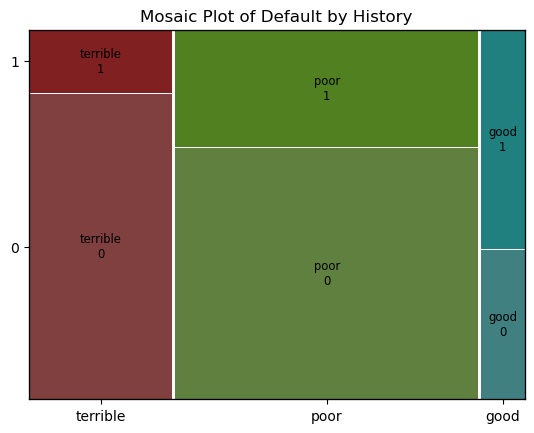

In [5]:

import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Assuming df is your DataFrame equivalent to the 'credit' data frame in R
# and it contains 'Default' and 'history' columns

# Create a mosaic plot
mosaic(db, ['history', 'Default'], title='Mosaic Plot of Default by History')
plt.ylabel('Default')
plt.show()


## Estimación Logit

\begin{align}
p_i &=\frac{e^{X_i\beta}}{1+e^{X_i\beta}}
\end{align}


In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



# Convert 'history' and 'purpose' into dummy variables
db_dummies = pd.get_dummies(db, columns=['history', 'purpose','foreign'], drop_first=True)

# Separate the independent and dependent variables
X = db_dummies.drop('Default', axis=1)
y = db_dummies['Default']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )




In [8]:
# Fit the logistic regression model
logit_model = LogisticRegression(max_iter=200 )
logit_model.fit(X_train,y_train)


LogisticRegression(max_iter=200)

## Prediction


\begin{align}
\hat{p}_i &=\frac{e^{X_i\hat{\beta}}}{1+e^{X_i\hat{\beta}}}
\end{align}

In [9]:
y_test=pd.DataFrame(y_test)
y_test.head()

,Default
681,0
990,0
155,1
768,0
438,0


In [10]:

# Predict the probabilities
y_test['prob_hat'] = logit_model.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


,Default,prob_hat
681,0,0.214564
990,0,0.187190
155,1,0.265616
768,0,0.163977
438,0,0.177238


# CARTs

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Creación del modelo
# ------------------------------------------------------------------------------
model_tree = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
model_tree.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 27


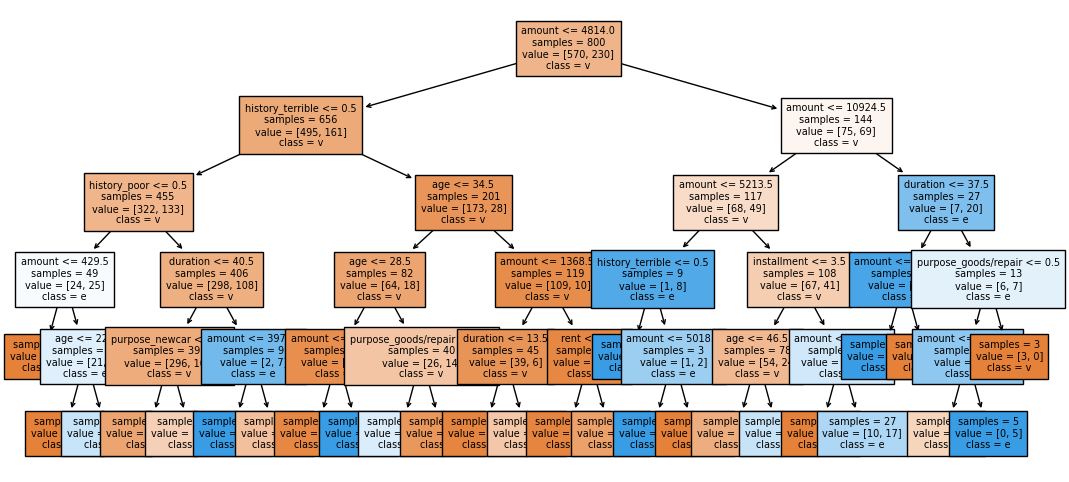

In [12]:
from sklearn.tree import plot_tree

# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {model_tree.get_depth()}")
print(f"Número de nodos terminales: {model_tree.get_n_leaves()}")

plot = plot_tree(
            decision_tree = model_tree,
            feature_names = X_train.columns,
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )



In [13]:

# Predict the probabilities
y_test['prob_hat_tree'] = model_tree.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


,Default,prob_hat,prob_hat_tree
681,0,0.214564,0.216828
990,0,0.187190,0.031250
155,1,0.265616,0.216828
768,0,0.163977,0.050000
438,0,0.177238,0.031250


### Pruning

In [14]:
from sklearn.model_selection import GridSearchCV

# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 0.005, 40)}
param_grid

{'ccp_alpha': array([0.        , 0.00012821, 0.00025641, 0.00038462, 0.00051282,
        0.00064103, 0.00076923, 0.00089744, 0.00102564, 0.00115385,
        0.00128205, 0.00141026, 0.00153846, 0.00166667, 0.00179487,
        0.00192308, 0.00205128, 0.00217949, 0.00230769, 0.0024359 ,
        0.0025641 , 0.00269231, 0.00282051, 0.00294872, 0.00307692,
        0.00320513, 0.00333333, 0.00346154, 0.00358974, 0.00371795,
        0.00384615, 0.00397436, 0.00410256, 0.00423077, 0.00435897,
        0.00448718, 0.00461538, 0.00474359, 0.00487179, 0.005     ])}

In [15]:
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score)



# Búsqueda por validación cruzada
grid_tree = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = f1_scorer,
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

grid_tree.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'ccp_alpha': array([0.        , 0.00012821, 0.00025641, 0.00038462, 0.00051282,
       0.00064103, 0.00076923, 0.00089744, 0.00102564, 0.00115385,
       0.00128205, 0.00141026, 0.00153846, 0.00166667, 0.00179487,
       0.00192308, 0.00205128, 0.00217949, 0.00230769, 0.0024359 ,
       0.0025641 , 0.00269231, 0.00282051, 0.00294872, 0.00307692,
       0.00320513, 0.00333333, 0.00346154, 0.00358974, 0.00371795,
       0.00384615, 0.00397436, 0.00410256, 0.00423077, 0.00435897,
       0.00448718, 0.00461538, 0.00474359, 0.00487179, 0.005     ])},
             return_train_score=True, scoring=make_scorer(f1_score))

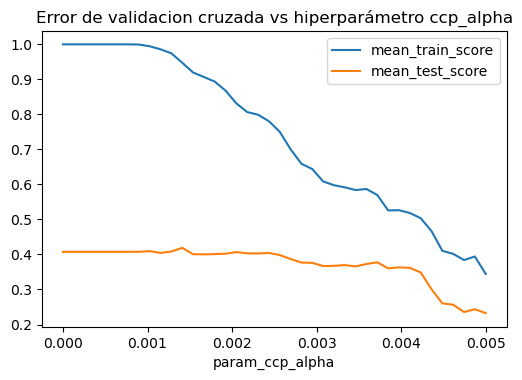

In [16]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid_tree.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");


In [17]:
grid_tree.best_params_

{'ccp_alpha': 0.0014102564102564104}

In [18]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
model_tree_final = grid_tree.best_estimator_
print(f"Profundidad del árbol: {model_tree_final.get_depth()}")
print(f"Número de nodos terminales: {model_tree_final.get_n_leaves()}")

Profundidad del árbol: 19
Número de nodos terminales: 120


In [19]:

# Predict the probabilities
y_test['prob_hat_tree_cp'] = model_tree_final.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


,Default,prob_hat,prob_hat_tree,prob_hat_tree_cp
681,0,0.214564,0.216828,0.06
990,0,0.187190,0.031250,0.00
155,1,0.265616,0.216828,0.00
768,0,0.163977,0.050000,0.05
438,0,0.177238,0.031250,0.00


## Random Forests

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
import multiprocessing

In [21]:


# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {
    'n_estimators': [150,200],
    'max_features': [5, 7, 9],
    'max_depth'   : [None, 3, 10, 20],
    'criterion'   : ['gini', 'entropy']
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid_forest = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_forest.fit(X = X_train, y = y_train)



GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestClassifier(random_state=123), n_jobs=7,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 10, 20],
                         'max_features': [5, 7, 9],
                         'n_estimators': [150, 200]},
             return_train_score=True, scoring='accuracy')

In [22]:

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_forest.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)


,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
17,gini,10,9,200,0.718750,0.022244,0.952813,0.007930
16,gini,10,9,150,0.718333,0.023102,0.951875,0.008032
6,gini,3,5,150,0.717917,0.031447,0.746458,0.007601
33,entropy,3,7,200,0.717917,0.032903,0.745625,0.007176


In [23]:


# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_forest.best_params_, ":", grid_forest.best_score_, grid_forest.scoring)



----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 200} : 0.71875 accuracy


In [24]:


model_grid_forest_final = grid_forest.best_estimator_

# Predict the probabilities
y_test['prob_hat_forest'] = model_grid_forest_final.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


,Default,prob_hat,prob_hat_tree,prob_hat_tree_cp,prob_hat_forest
681,0,0.214564,0.216828,0.06,0.307525
990,0,0.187190,0.031250,0.00,0.180372
155,1,0.265616,0.216828,0.00,0.253080
768,0,0.163977,0.050000,0.05,0.232648
438,0,0.177238,0.031250,0.00,0.201063


## Importancia de predictores
### Importancia por pureza de nodos

In [25]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': model_grid_forest_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,amount,0.336461
3,age,0.220382
0,duration,0.172599
2,installment,0.057820
6,history_terrible,0.039905
9,purpose_newcar,0.039265
5,history_poor,0.035216
4,rent,0.030756
10,purpose_usedcar,0.021788
8,purpose_goods/repair,0.021354


###  Importancia por permutación

In [26]:
from sklearn.inspection import permutation_importance

importancia = permutation_importance(
                estimator    = model_grid_forest_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'accuracy',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)



,importances_mean,importances_std,feature
1,0.18450,0.022003,amount
0,0.13550,0.005679,duration
3,0.10450,0.005734,age
9,0.05625,0.005184,purpose_newcar
6,0.05525,0.003000,history_terrible
4,0.02475,0.003102,rent
2,0.01800,0.001275,installment
5,0.01250,0.006847,history_poor
8,0.00850,0.002151,purpose_goods/repair
7,0.00850,0.000935,purpose_edu


# AdaBoost

In [27]:
from sklearn.ensemble import AdaBoostClassifier

In [28]:
model_ada= AdaBoostClassifier(
                DecisionTreeClassifier(max_depth=2),
                                      n_estimators=300
)

In [29]:
# Entrenamiento del modelo
# ------------------------------------------------------------------------------
model_ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=300)

In [30]:
# Predict the probabilities
y_test['prob_hat_ada'] = model_ada.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


,Default,prob_hat,prob_hat_tree,prob_hat_tree_cp,prob_hat_forest,prob_hat_ada
681,0,0.214564,0.216828,0.06,0.307525,0.494544
990,0,0.187190,0.031250,0.00,0.180372,0.468912
155,1,0.265616,0.216828,0.00,0.253080,0.497393
768,0,0.163977,0.050000,0.05,0.232648,0.481479
438,0,0.177238,0.031250,0.00,0.201063,0.482315


# Classification and Missclasification



\begin{align}
\hat{Y}_i= 1[\hat{p}_i >0.5]
\end{align}

In [31]:

# Define the rule (threshold)
rule = 0.5

# Create the predicted class labels based on the rule
y_test['Default_hat_logit'] = (y_test['prob_hat'] > rule).astype(int)

# Display the first few rows of the specified columns
y_test[['Default', 'prob_hat', 'Default_hat_logit']].head(30)

,Default,prob_hat,Default_hat_logit
681,0,0.214564,0
990,0,0.187190,0
155,1,0.265616,0
768,0,0.163977,0
438,0,0.177238,0
363,0,0.215117,0
688,0,0.185587,0
555,1,0.162870,0
620,0,0.182760,0
99,0,0.277222,0


In [32]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_logit'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")




El accuracy de test es: 68.5%


In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_logit'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix



Predicción,0,1
Real,,
0,121,9
1,54,16


## Trees

In [34]:

# Create the predicted class labels based on the rule
y_test['Default_hat_tree'] = (y_test['prob_hat_tree'] > rule).astype(int)


In [35]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_tree'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")




El accuracy de test es: 66.5%


In [36]:

# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_tree'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,114,16
1,51,19


## Trees CP

In [37]:

# Create the predicted class labels based on the rule
y_test['Default_hat_tree_cp'] = (y_test['prob_hat_tree_cp'] > rule).astype(int)


In [38]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_tree_cp'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")




El accuracy de test es: 63.5%


In [39]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_tree_cp'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,101,29
1,44,26


## Forest

In [40]:

# Create the predicted class labels based on the rule
y_test['Default_hat_forest'] = (y_test['prob_hat_forest'] > rule).astype(int)


In [41]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_forest'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")




El accuracy de test es: 68.5%


In [42]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_forest'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,120,10
1,53,17


## AdaBoost

In [43]:

# Create the predicted class labels based on the rule
y_test['Default_hat_ada'] = (y_test['prob_hat_ada'] > rule).astype(int)


In [44]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_ada'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")




El accuracy de test es: 64.0%


In [45]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_ada'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,105,25
1,47,23


In [46]:
from sklearn.metrics import f1_score



# Dictionary to hold F1 scores
f1_scores = {}

f1_scores['Logit'] = f1_score(    y_test['Default'], y_test['Default_hat_logit'])
f1_scores['CART'] = f1_score(    y_test['Default'], y_test['Default_hat_tree'])
f1_scores['CART CP'] = f1_score(    y_test['Default'], y_test['Default_hat_tree_cp'])
f1_scores['Forest'] = f1_score(    y_test['Default'], y_test['Default_hat_forest'])
f1_scores['AdaBoost'] = f1_score(    y_test['Default'], y_test['Default_hat_ada'])


In [47]:
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Model', 'F1 Score'])
print(f1_df)

      Model  F1 Score
0     Logit  0.336842
1      CART  0.361905
2   CART CP  0.416000
3    Forest  0.350515
4  AdaBoost  0.389831


In [48]:
from sklearn.metrics import roc_curve, auc


models = {
    'Logit': logit_model,
    'CART': model_tree,
    'CART CP': model_tree_final,
    'Random Forest': model_grid_forest_final,
    'AdaBoost': model_ada
}

auc_scores = {}


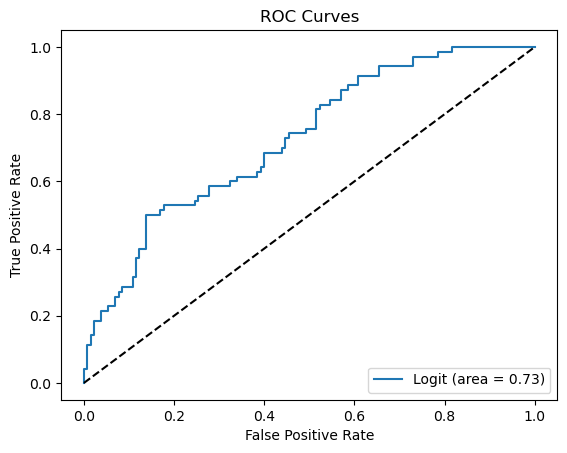

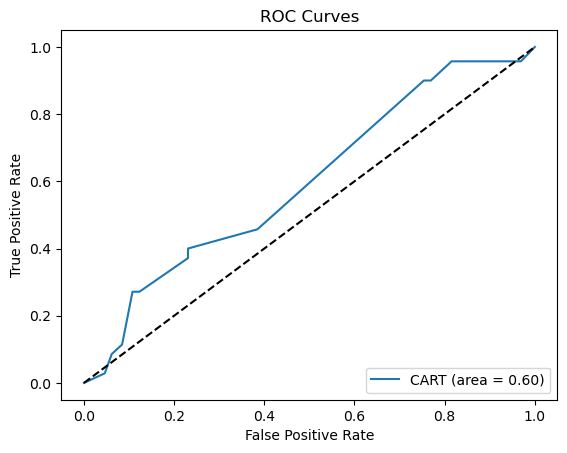

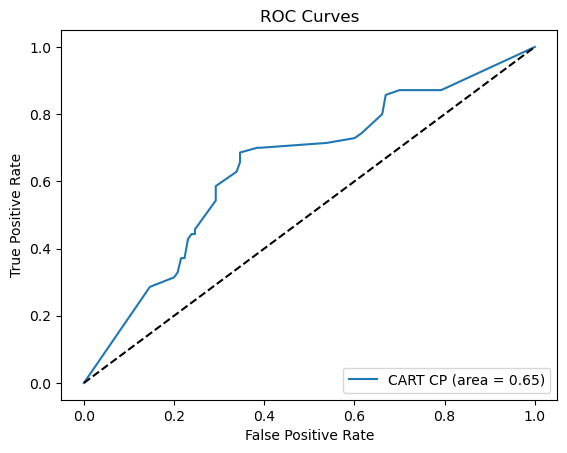

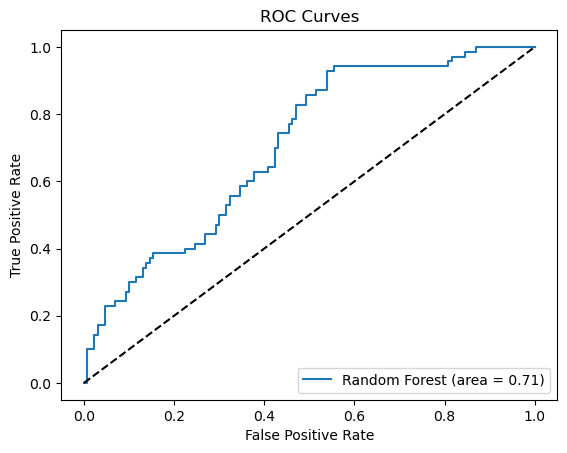

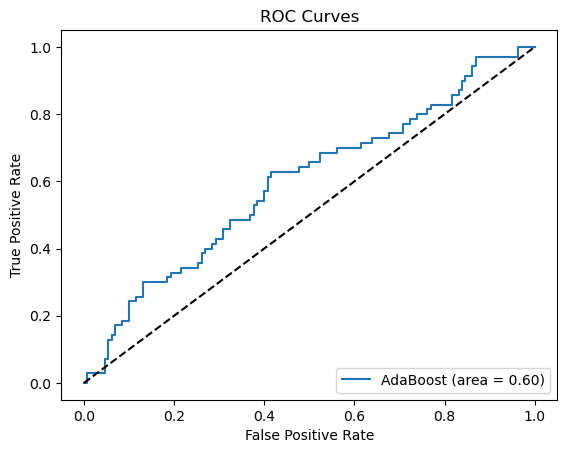

In [49]:

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test['Default'], y_pred_prob)
    roc_auc = auc(fpr, tpr)
    auc_scores[name] = roc_auc

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

In [50]:
# Create DataFrame for AUC scores
auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Model', 'AUC Score'])
auc_df

,Model,AUC Score
0,Logit,0.725495
1,CART,0.597637
2,CART CP,0.645385
3,Random Forest,0.705275
4,AdaBoost,0.596044


In [51]:
fpr, tpr, thresholds = roc_curve(y_test['Default'], y_test['prob_hat'])

# Calculate the Euclidean distance for each point on the ROC curve from the top-left corner
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)

# Find the optimal threshold
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.3215740342545934

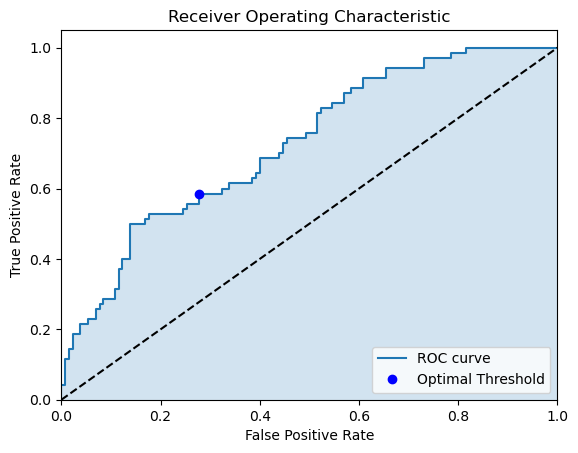

In [52]:

plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'bo', label='Optimal Threshold')
plt.fill_between(fpr, tpr, alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [53]:

# Create the predicted class labels based on the rule
y_test['Default_hat_optimal'] = (y_test['prob_hat'] > optimal_threshold).astype(int)


In [54]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_optimal'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")




El accuracy de test es: 67.0%


In [55]:


print(f"El F1 de test es: {100*f1_score(    y_test['Default'], y_test['Default_hat_logit'])}%")

El F1 de test es: 33.684210526315795%


In [56]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_logit'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,121,9
1,54,16
